# Introduction

* This notebook contains an implementation of reinforcement learning with simple q learning from scratch (using only numpy). I used this implementation to solve the mountain car environment (of Gym by OpenAI - https://gym.openai.com/envs/MountainCar-v0/ ).
<img src="Images/MountainCar.jpg" alt="drawing" style="width:400px">
* Using this implementation of q learning, I was able to solve the environment, so at some point the car had succeeded to reach the goal in every episode (the uphill flag), as can be seen in the graphs below.
* I didn't spend too much time on tuning the config to be ideal, because after several tries of choosing the hyper parameters manually it worked pretty good. I guess that using a tuning algorithm  to choose the hyper parameters could improve the results a lot, especially in terms of number of episodes until the agent solves the environment.

# Import and functions

In [1]:
import os
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from q_learning_functions import create_q_table, get_discrete_state, get_action, calculate_q_value, \
                                 update_q_table, update_epsilon, update_learning_rate, \
                                 render_env, update_stats, plot_learning_results

In [2]:
def plot_q_table_per_action(q_table):

    def get_q_color(value, vals):
        if value == max(vals):
            return "green", 1.0
        else:
            return "red", 0.3

    fig = plt.figure(figsize=(12, 9))

    ax1 = fig.add_subplot(3,1,1)
    ax2 = fig.add_subplot(3,1,2)
    ax3 = fig.add_subplot(3,1,3)

    for x, x_vals in enumerate(q_table):
        for y, y_vals in enumerate(x_vals):
            ax1.scatter(x, y, c=get_q_color(y_vals[0], y_vals)[0], marker="o", alpha=get_q_color(y_vals[0], y_vals)[1])
            ax2.scatter(x, y, c=get_q_color(y_vals[1], y_vals)[0], marker="o", alpha=get_q_color(y_vals[1], y_vals)[1])
            ax3.scatter(x, y, c=get_q_color(y_vals[2], y_vals)[0], marker="o", alpha=get_q_color(y_vals[2], y_vals)[1])

            ax1.set_ylabel("Action 0")
            ax2.set_ylabel("Action 1")
            ax3.set_ylabel("Action 2")

    plt.show()

# Config

In [3]:
# General settings
ENV_NAME = "MountainCar-v0"
env = gym.make(ENV_NAME)

DISCOUNT = 0.99
EPISODES = 60_000
SHOW_EVERY = 3_000
STATS_EVERY = 100
PRINT_EVERY = STATS_EVERY * 20
SAVE_EVERY = 30
TO_PRINT = True
TO_RENDER = True

DISCRETE_OS_SIZE = [20] * len(env.observation_space.high)
discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/DISCRETE_OS_SIZE

In [4]:
# Exploration settings
MIN_EPSILON, MAX_EPSILON = 0, 1
START_EPSILON_DECAYING, END_EPSILON_DECAYING =  1, EPISODES//2
EPSILON_DECAY_VALUE = (MAX_EPSILON - MIN_EPSILON)/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)
epsilon = MAX_EPSILON  # not a constant, going to be decayed

# Learning_rate settings
MIN_LEARNING_RATE, MAX_LEARNING_RATE = 0.1, 0.5
START_LEARNING_RATE_DECAYING, END_LEARNING_RATE_DECAYING =  1, EPISODES//2
LEARNING_RATE_DECAY_VALUE = (MAX_LEARNING_RATE - MIN_LEARNING_RATE)/(END_LEARNING_RATE_DECAYING - START_LEARNING_RATE_DECAYING)
learning_rate = MAX_LEARNING_RATE  # not a constant, going to be decayed

In [5]:
# Stats settings
ep_rewards = []
aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}
q_table = create_q_table(low_value=-2, high_value=0, size=(DISCRETE_OS_SIZE + [env.action_space.n]))

# Model

In [6]:
for episode in range(EPISODES):
    episode_reward = 0
    
    discrete_state = get_discrete_state(env, env.reset(), discrete_os_win_size)
    done = False

    while not done:
        
        action = get_action(env, epsilon, discrete_state, q_table)
        new_state, reward, done, _ = env.step(action)
        episode_reward += reward

        new_discrete_state = get_discrete_state(env, new_state, discrete_os_win_size)
        render_env(env, episode, SHOW_EVERY, TO_RENDER)

        # If simulation did not end yet after last step - update Q table
        if not done:
            q_table = update_q_table(q_table, discrete_state, new_discrete_state, \
                                     action, reward, learning_rate, DISCOUNT)
        # Simulation ended (for any reson) - 
        # if goal position is achived - update Q value with reward directly
        elif hasattr(env, 'goal_position'):
            if new_state[0] >= env.goal_position:
                q_table[discrete_state + (action,)] = 0

        discrete_state = new_discrete_state

    epsilon = update_epsilon(episode, epsilon, EPSILON_DECAY_VALUE, \
                             START_EPSILON_DECAYING, END_EPSILON_DECAYING)
    learning_rate = update_learning_rate(episode, learning_rate, LEARNING_RATE_DECAY_VALUE, 
                                         START_LEARNING_RATE_DECAYING, END_LEARNING_RATE_DECAYING)
    ep_rewards.append(episode_reward)
    aggr_ep_rewards = update_stats(q_table=q_table, episode=episode, epsilon=epsilon, 
                                   ep_rewards=ep_rewards, aggr_ep_rewards=aggr_ep_rewards, 
                                   learning_rate=learning_rate, STATS_EVERY=STATS_EVERY, PRINT_EVERY=PRINT_EVERY, 
                                   SAVE_EVERY=SAVE_EVERY, TO_PRINT=TO_PRINT,
                                   folder=f"{ENV_NAME}_qtables/", file_name=f"{episode}-qtable.npy")
        
env.close()

Episode:   2000, average reward: -200.0, current epsilon: 0.93, current learning_rate: 0.47
Episode:   4000, average reward: -200.0, current epsilon: 0.87, current learning_rate: 0.45
Episode:   6000, average reward: -200.0, current epsilon: 0.80, current learning_rate: 0.42
Episode:   8000, average reward: -200.0, current epsilon: 0.73, current learning_rate: 0.39
Episode:  10000, average reward: -200.0, current epsilon: 0.67, current learning_rate: 0.37
Episode:  12000, average reward: -200.0, current epsilon: 0.60, current learning_rate: 0.34
Episode:  14000, average reward: -200.0, current epsilon: 0.53, current learning_rate: 0.31
Episode:  16000, average reward: -200.0, current epsilon: 0.47, current learning_rate: 0.29
Episode:  18000, average reward: -200.0, current epsilon: 0.40, current learning_rate: 0.26
Episode:  20000, average reward: -198.6, current epsilon: 0.33, current learning_rate: 0.23
Episode:  22000, average reward: -196.7, current epsilon: 0.27, current learning

# Results

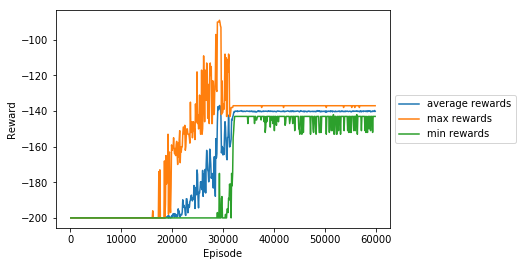

In [7]:
plot_learning_results(aggr_ep_rewards)

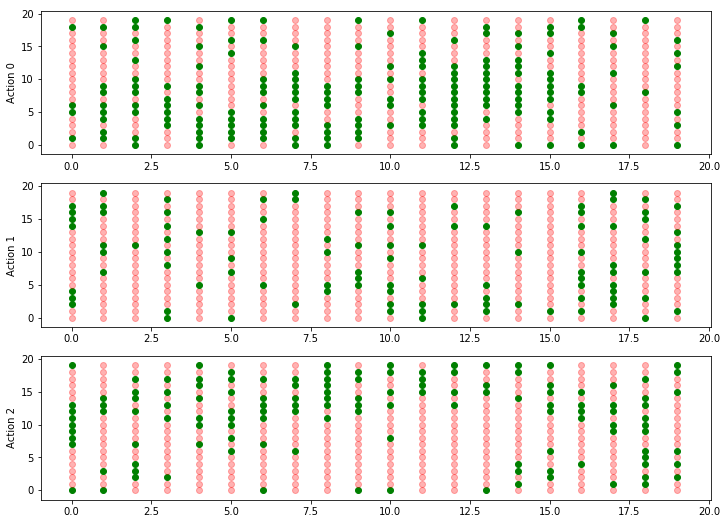

In [8]:
folder = f"{ENV_NAME}_qtables"
qtable_index=(episode-(episode%SAVE_EVERY))
final_q_table = np.load(f"{folder}/{qtable_index}-qtable.npy")
plot_q_table_per_action(final_q_table)